In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image, ImageOps

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from IPython.display import display


In [2]:
image_dir = Path("MURA-v1.1")   # корень с исходными картинками
extensions = {".png", ".jpg", ".jpeg"}  # на всякий случай

def collect_image_dimensions(root_dir: Path):
    records = []
    for path in root_dir.rglob("*"):
        if path.suffix.lower() in extensions and not path.name.startswith("._"):
            try:
                with Image.open(path) as img:
                    w, h = img.size
            except Exception as e:
                print(f"⚠️ Ошибка при чтении {path}: {e}")
                continue
            records.append(
                {
                    "path": path,
                    "width": w,
                    "height": h,
                    "aspect_ratio": w / h if h != 0 else np.nan,
                }
            )
    df = pd.DataFrame(records)
    print(f"Всего найдено изображений: {len(df)}")
    return df

df_dimensions = collect_image_dimensions(image_dir)
display(df_dimensions.head())


Всего найдено изображений: 40005


,path,width,height,aspect_ratio
0,MURA-v1.1/train/XR_HAND/patient10502/study1_ne...,336,512,0.656250
1,MURA-v1.1/train/XR_HAND/patient10502/study1_ne...,336,512,0.656250
2,MURA-v1.1/train/XR_HAND/patient10502/study1_ne...,322,512,0.628906
3,MURA-v1.1/train/XR_HAND/patient09246/study1_ne...,278,512,0.542969
4,MURA-v1.1/train/XR_HAND/patient09246/study1_ne...,316,512,0.617188


In [3]:
# Убираем NaN на всякий случай
df_clean = df_dimensions.dropna(subset=["aspect_ratio"]).copy()

X = df_clean[["aspect_ratio"]].values

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init="auto"  # если sklearn>=1.4, иначе можно убрать этот параметр
)

df_clean["ar_cluster"] = kmeans.fit_predict(X)

# Подмешаем обратно в оригинальный df по path
df_dimensions = df_dimensions.merge(
    df_clean[["path", "ar_cluster"]],
    on="path",
    how="left"
)

cluster_stats = (
    df_dimensions
    .groupby("ar_cluster")
    .agg(
        count=("aspect_ratio", "size"),
        mean_ar=("aspect_ratio", "mean"),
        median_ar=("aspect_ratio", "median"),
        std_ar=("aspect_ratio", "std"),
        mean_w=("width", "mean"),
        median_w=("width", "median"),
        std_w=("width", "std"),
        mean_h=("height", "mean"),
        median_h=("height", "median"),
        std_h=("height", "std"),
    )
)
display(cluster_stats)


,count,mean_ar,median_ar,std_ar,mean_w,median_w,std_w,mean_h,median_h,std_h
ar_cluster,,,,,,,,,,
0,7785,1.293487,1.261084,0.247560,512.000000,512.0,0.000000,404.153243,406.0,46.086209
1,23995,0.806505,0.792969,0.077577,412.657512,406.0,38.975324,511.735195,512.0,2.002285
2,8225,0.496859,0.511719,0.102084,254.391733,262.0,52.266841,512.000000,512.0,0.000000


In [8]:
# Размеры, рекомендованные chatgpt как более оптимальные
# TARGET_H = 256
# TARGET_W = 320
TARGET_H = 224
TARGET_W = 224

def resize_with_padding(img: Image.Image,
                        target_h: int = TARGET_H,
                        target_w: int = TARGET_W) -> Image.Image:
    """
    Ресайз изображения с сохранением пропорций + центрированный паддинг
    до (target_h, target_w).
    """
    w, h = img.size

    # Первый шаг: пробуем масштабировать по высоте
    if h > 0:
        scale = target_h / h
    else:
        scale = 1.0

    new_w = int(round(w * scale))
    new_h = int(round(h * scale))

    # Если по высоте всё хорошо, но ширина вдруг слишком большая — масштабируем по ширине
    if new_w > target_w:
        scale = target_w / w
        new_w = int(round(w * scale))
        new_h = int(round(h * scale))

    # Собственно ресайз
    img_resized = img.resize((new_w, new_h), Image.BILINEAR)

    # Паддинг до нужного размера
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top

    # Фон чёрный (0), под рентгены как раз
    img_padded = ImageOps.expand(
        img_resized,
        border=(pad_left, pad_top, pad_right, pad_bottom),
        fill=0
    )

    return img_padded


In [10]:
output_root = Path(f"MURA-v1.1-resized-{TARGET_W}x{TARGET_H}")
output_root.mkdir(parents=True, exist_ok=True)

def save_resized_dataset(df: pd.DataFrame,
                         input_root: Path,
                         output_root: Path):
    num_saved = 0
    for i, row in df.iterrows():
        src_path: Path = row["path"]
        rel_path = src_path.relative_to(input_root)  # относительный путь от корня
        dst_path = output_root / rel_path

        dst_path.parent.mkdir(parents=True, exist_ok=True)

        try:
            with Image.open(src_path) as img:
                img = img.convert("L")  # на всякий случай делаем grayscale
                img_resized = resize_with_padding(img)
                img_resized.save(dst_path)
            num_saved += 1
        except Exception as e:
            print(f"⚠️ Ошибка при обработке {src_path}: {e}")

    print(f"Готово! Сохранено изображений: {num_saved}")

save_resized_dataset(df_dimensions, image_dir, output_root)


Готово! Сохранено изображений: 40005



=== Кластер 0 ===


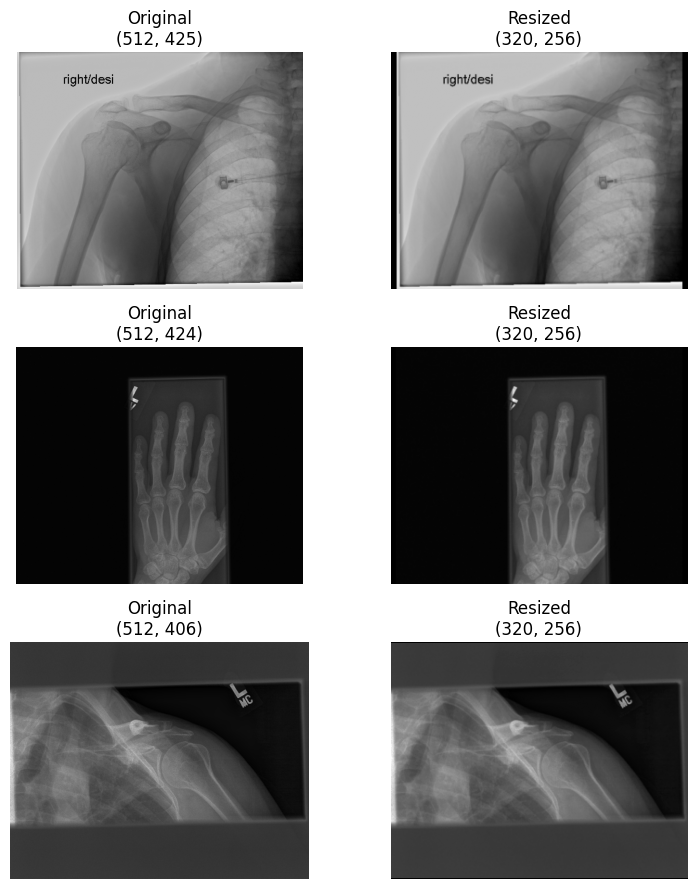


=== Кластер 1 ===


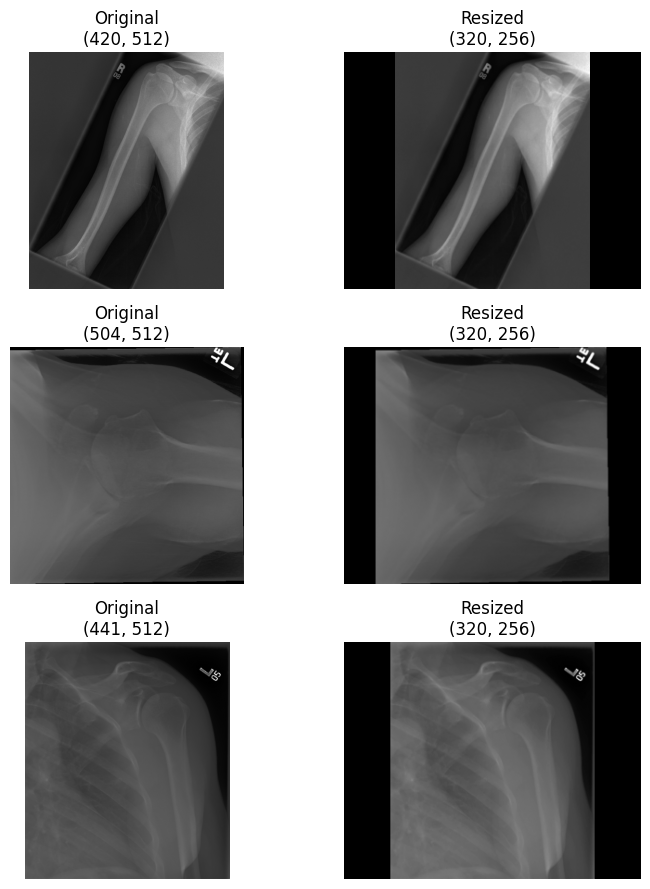


=== Кластер 2 ===


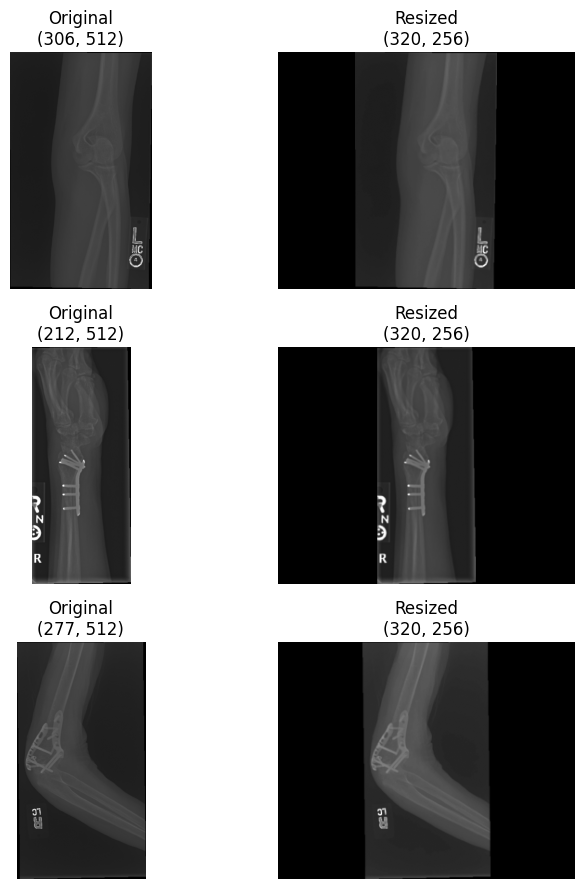

In [6]:
def show_cluster_examples(df: pd.DataFrame,
                          input_root: Path,
                          output_root: Path,
                          samples_per_cluster: int = 3):
    clusters = sorted(df["ar_cluster"].dropna().unique())
    for cl in clusters:
        print(f"\n=== Кластер {cl} ===")
        df_cl = df[df["ar_cluster"] == cl].sample(
            n=min(samples_per_cluster, (df["ar_cluster"] == cl).sum()),
            random_state=42
        )

        fig, axes = plt.subplots(
            nrows=samples_per_cluster,
            ncols=2,
            figsize=(8, 3 * samples_per_cluster)
        )

        if samples_per_cluster == 1:
            axes = np.array([axes])  # чтобы всегда была 2D-матрица

        for row_idx, (_, row) in enumerate(df_cl.iterrows()):
            src_path: Path = row["path"]
            rel_path = src_path.relative_to(input_root)
            dst_path = output_root / rel_path

            # Оригинал
            try:
                with Image.open(src_path) as img_orig:
                    axes[row_idx, 0].imshow(img_orig, cmap="gray")
                    axes[row_idx, 0].set_title(f"Original\n{img_orig.size}")
                    axes[row_idx, 0].axis("off")
            except Exception as e:
                axes[row_idx, 0].set_title(f"Ошибка чтения\n{src_path}")
                axes[row_idx, 0].axis("off")

            # Ресайз
            try:
                with Image.open(dst_path) as img_resized:
                    axes[row_idx, 1].imshow(img_resized, cmap="gray")
                    axes[row_idx, 1].set_title(f"Resized\n{img_resized.size}")
                    axes[row_idx, 1].axis("off")
            except Exception as e:
                axes[row_idx, 1].set_title(f"Нет файла\n{dst_path}")
                axes[row_idx, 1].axis("off")

        plt.tight_layout()
        plt.show()

show_cluster_examples(df_dimensions, image_dir, output_root, samples_per_cluster=3)
